In [6]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

In [7]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA


In [8]:
import numpy as np
import pandas as pd
import warnings

# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]


# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

# Função OBV ajustada
def obv(group, smoothed_col):
    Volume = group['Volume']
    change = group[smoothed_col].diff()
    prev_obv = 0
    obv_values = []
    for i, j in zip(change, Volume):
        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv
        prev_obv = current_obv
        obv_values.append(current_obv)
    return pd.Series(obv_values, index=group.index)

# Lista de alphas e parâmetros gerais
alpha_list = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
n = 10
d = 30
t = 14
e = 14

# Loop para cálculos por alpha
for alpha in alpha_list:
    smoothed_col = f'Smoothed_Close_{alpha:.2f}'
    target_col = f'Prediction_{alpha:.2f}'
    obv_col = f'OBV_{alpha:.2f}'
    price_rate_col = f'Price_Rate_Of_Change_{alpha:.2f}'
    macd_col = f'MACD_{alpha:.2f}'
    macd_ema_col = f'MACD_EMA_{alpha:.2f}'
    low_col = f'low_{t}_{alpha:.2f}'
    high_col = f'high_{t}_{alpha:.2f}'
    k_percent_col = f'k_percent_{alpha:.2f}'
    r_percent_col = f'r_percent_{alpha:.2f}'
    
    # Suavização exponencial
    price_data[smoothed_col] = price_data.groupby('Ticker')['Close'].transform(
        lambda x: exponential_smoothing(x.values, alpha)
    )
    
    # Target
    price_data[target_col] = price_data.groupby('Ticker')[smoothed_col].transform(
        lambda x: calculate_target(x, d)
    )
    
    # OBV
    obv_groups = price_data.groupby('Ticker').apply(lambda group: obv(group, smoothed_col))
    price_data[obv_col] = obv_groups.reset_index(level=0, drop=True)
    
    # Price Rate of Change
    price_data[price_rate_col] = price_data.groupby('Ticker')[smoothed_col].transform(
        lambda x: x.pct_change(periods=e)
    )
    
    
    # %R
    low_t = price_data[['Ticker', 'Low']].copy()
    high_t = price_data[['Ticker', 'High']].copy()
    low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=t).min())
    high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=t).max())
    r_percent = ((high_t - price_data[smoothed_col]) / (high_t - low_t)) * (-100)
    price_data[low_col] = low_t
    price_data[high_col] = high_t
    price_data[r_percent_col] = r_percent

    # %K    
    k_percent = ((price_data[smoothed_col] - low_t) / (high_t - low_t)) * 100
    price_data[k_percent_col] = k_percent
    
    # MACD
    ema_26 = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.ewm(span=26).mean())
    ema_12 = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.ewm(span=12).mean())
    macd = ema_12 - ema_26
    ema_9_macd = macd.ewm(span=9).mean()
    price_data[macd_col] = macd
    price_data[macd_ema_col] = ema_9_macd

    # Calculando o Price Rate of Change (ROC) usando a coluna suavizada correspondente
    price_data[price_rate_col] = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.pct_change(periods=e))


# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)


price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)

# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()
# Desativa warnings
warnings.filterwarnings("ignore")
# Visualização final
price_data.tail()




,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close_0.10,Prediction_0.10,OBV_0.10,Price_Rate_Of_Change_0.10,low_14_0.10,high_14_0.10,r_percent_0.10,k_percent_0.10,MACD_0.10,MACD_EMA_0.10,Smoothed_Close_0.20,Prediction_0.20,OBV_0.20,Price_Rate_Of_Change_0.20,low_14_0.20,high_14_0.20,r_percent_0.20,k_percent_0.20,MACD_0.20,MACD_EMA_0.20,Smoothed_Close_0.30,Prediction_0.30,OBV_0.30,Price_Rate_Of_Change_0.30,low_14_0.30,high_14_0.30,r_percent_0.30,k_percent_0.30,MACD_0.30,MACD_EMA_0.30,Smoothed_Close_0.40,Prediction_0.40,OBV_0.40,Price_Rate_Of_Change_0.40,low_14_0.40,high_14_0.40,r_percent_0.40,k_percent_0.40,MACD_0.40,MACD_EMA_0.40,Smoothed_Close_0.50,Prediction_0.50,OBV_0.50,Price_Rate_Of_Change_0.50,low_14_0.50,high_14_0.50,r_percent_0.50,k_percent_0.50,MACD_0.50,MACD_EMA_0.50,Smoothed_Close_0.60,Prediction_0.60,OBV_0.60,Price_Rate_Of_Change_0.60,low_14_0.60,high_14_0.60,r_percent_0.60,k_percent_0.60,MACD_0.60,MACD_EMA_0.60,Smoothed_Close_0.70,Prediction_0.70,OBV_0.70,Price_Rate_Of_Change_0.70,low_14_0.70,high_14_0.70,r_percent_0.70,k_percent_0.70,MACD_0.70,MACD_EMA_0.70,Smoothed_Close_0.80,Prediction_0.80,OBV_0.80,Price_Rate_Of_Change_0.80,low_14_0.80,high_14_0.80,r_percent_0.80,k_percent_0.80,MACD_0.80,MACD_EMA_0.80,Smoothed_Close_0.90,Prediction_0.90,OBV_0.90,Price_Rate_Of_Change_0.90,low_14_0.90,high_14_0.90,r_percent_0.90,k_percent_0.90,MACD_0.90,MACD_EMA_0.90,down_days,up_days,RSI,Smoothed_Close_1,Verify,Close_10
11749,2024-12-04,58.400002,58.480000,56.959999,57.330002,56.822830,25109200,VALE3.SA,-1.139999,58.661428,-1.0,2813674648,-0.038346,56.84,59.380001,-28.290269,71.709731,-0.570612,-0.419024,58.150667,-1.0,2407909370,-0.038312,56.84,59.380001,-48.398976,51.601024,-0.760099,-0.680823,58.068330,-1.0,532845562,-0.029590,56.84,59.380001,-51.640561,48.359439,-0.765127,-0.753059,58.013399,-1.0,938487966,-0.020875,56.84,59.380001,-53.803222,46.196778,-0.742717,-0.770527,57.929372,-1.0,866384726,-0.013778,56.84,59.380001,-57.111354,42.888646,-0.723821,-0.772191,57.821384,-1.0,476947038,-0.008380,56.84,59.380001,-61.362843,38.637157,-0.712087,-0.769701,57.699695,-1.0,594582542,-0.004507,56.84,59.380001,-66.153743,33.846257,-0.706276,-0.766557,57.573038,-1.0,-1007457842,-0.001949,56.84,59.380001,-71.140252,28.859748,-0.704759,-0.763788,57.448242,-1.0,-841746538,-0.000475,56.84,59.380001,-76.053475,23.946525,-0.706185,-0.761639,1.139999,0.000000,36.001861,57.330002,-1.0,54.020000
11750,2024-12-05,57.459999,57.799999,56.869999,57.799999,57.288670,14160000,VALE3.SA,0.469997,58.575285,-1.0,2799514648,-0.033674,56.84,59.380001,-31.681719,68.318281,-0.583073,-0.451833,58.080533,-1.0,2393749370,-0.028849,56.84,59.380001,-51.160136,48.839864,-0.747122,-0.694083,57.987831,-1.0,518685562,-0.017742,56.84,59.380001,-54.809825,45.190175,-0.744154,-0.751278,57.928039,-1.0,924327966,-0.008322,56.84,59.380001,-57.163843,42.836157,-0.723716,-0.761165,57.864686,-1.0,852224726,-0.001461,56.84,59.380001,-59.658064,40.341936,-0.709518,-0.759656,57.808553,-1.0,462787038,0.003272,56.84,59.380001,-61.868002,38.131998,-0.701964,-0.756153,57.769908,-1.0,608742542,0.006439,56.84,59.380001,-63.389465,36.610535,-0.698534,-0.752952,57.754607,-1.0,-993297842,0.008548,56.84,59.380001,-63.991870,36.008130,-0.697124,-0.750455,57.764824,-1.0,-827586538,0.010024,56.84,59.380001,-63.589644,36.410356,-0.696312,-0.748574,0.000000,0.469997,44.510045,57.799999,-1.0,52.660000
11751,2024-12-06,57.470001,57.660000,56.750000,56.810001,56.307430,17897900,VALE3.SA,-0.989998,58.398757,-1.0,2781616748,-0.030547,56.75,59.380001,-37.309655,62.690345,-0.600272,-0.481521,57.826427,-1.0,2375851470,-0.023411,56.75,59.380001,-59.071241,40.928759,-0.748711,-0.705009,57.634482,-1.0,500787662,-0.012714,56.75,59.380001,-66.369515,33.630485,-0.747428,-0.750508,57.480824,-1.0,906430066,-0.005255,56.75,59.380001,-72.212030,27.787970,-0.736258,-0.756184,57.337344,-1.0,834326826,-0.000999,56.75,59.380001,-77.667555,22.332445,-0.732294,-0.754184,57.209422,-1.0,4

#### Se quiser rodar para um Ticker.

In [9]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close_0.10,Prediction_0.10,OBV_0.10,Price_Rate_Of_Change_0.10,low_14_0.10,high_14_0.10,r_percent_0.10,k_percent_0.10,MACD_0.10,MACD_EMA_0.10,Smoothed_Close_0.20,Prediction_0.20,OBV_0.20,Price_Rate_Of_Change_0.20,low_14_0.20,high_14_0.20,r_percent_0.20,k_percent_0.20,MACD_0.20,MACD_EMA_0.20,Smoothed_Close_0.30,Prediction_0.30,OBV_0.30,Price_Rate_Of_Change_0.30,low_14_0.30,high_14_0.30,r_percent_0.30,k_percent_0.30,MACD_0.30,MACD_EMA_0.30,Smoothed_Close_0.40,Prediction_0.40,OBV_0.40,Price_Rate_Of_Change_0.40,low_14_0.40,high_14_0.40,r_percent_0.40,k_percent_0.40,MACD_0.40,MACD_EMA_0.40,Smoothed_Close_0.50,Prediction_0.50,OBV_0.50,Price_Rate_Of_Change_0.50,low_14_0.50,high_14_0.50,r_percent_0.50,k_percent_0.50,MACD_0.50,MACD_EMA_0.50,Smoothed_Close_0.60,Prediction_0.60,OBV_0.60,Price_Rate_Of_Change_0.60,low_14_0.60,high_14_0.60,r_percent_0.60,k_percent_0.60,MACD_0.60,MACD_EMA_0.60,Smoothed_Close_0.70,Prediction_0.70,OBV_0.70,Price_Rate_Of_Change_0.70,low_14_0.70,high_14_0.70,r_percent_0.70,k_percent_0.70,MACD_0.70,MACD_EMA_0.70,Smoothed_Close_0.80,Prediction_0.80,OBV_0.80,Price_Rate_Of_Change_0.80,low_14_0.80,high_14_0.80,r_percent_0.80,k_percent_0.80,MACD_0.80,MACD_EMA_0.80,Smoothed_Close_0.90,Prediction_0.90,OBV_0.90,Price_Rate_Of_Change_0.90,low_14_0.90,high_14_0.90,r_percent_0.90,k_percent_0.90,MACD_0.90,MACD_EMA_0.90,down_days,up_days,RSI,Smoothed_Close_1,Verify,Close_10
5716,2024-12-04,13.90,14.06,13.78,13.93,13.663173,50659000,ABEV3.SA,0.08,12.901494,-1.0,-2636847193,0.015433,12.25,14.06,-64.005852,35.994148,-0.032105,-0.057489,13.132494,-1.0,-2161176047,0.043483,12.25,14.06,-51.243461,48.756539,-0.000375,-0.063355,13.348850,-1.0,-2336393773,0.064378,12.25,14.06,-39.290045,60.709955,0.036643,-0.052200,13.523489,-1.0,-1635196423,0.079408,12.25,14.06,-29.641502,70.358498,0.067437,-0.041062,13.65952,-1.0,-1460626405,0.090165,12.25,14.06,-22.125960,77.874040,0.092734,-0.031411,13.761963,-1.0,-1148289287,0.097644,12.25,14.06,-16.466174,83.533826,0.113548,-0.023160,13.835684,-1.0,-1338515275,0.102555,12.25,14.06,-12.393168,87.606832,0.130617,-0.016094,13.885363,-1.0,-1248445935,0.105475,12.25,14.06,-9.648449,90.351551,0.144511,-0.010034,13.915449,-1.0,-1183495073,0.106912,12.25,14.06,-7.986272,92.013728,0.155711,-0.004835,0.00,0.08,86.876242,13.93,-1.0,11.25
5717,2024-12-05,14.05,14.46,14.00,14.42,14.143786,38794000,ABEV3.SA,0.49,13.053345,-1.0,-2598053193,0.027186,12.25,14.46,-63.649557,36.350443,-0.002498,-0.046491,13.389995,-1.0,-2122382047,0.061502,12.25,14.46,-48.416523,51.583477,0.052492,-0.040186,13.670195,-1.0,-2297599773,0.085107,12.25,14.46,-35.737769,64.262231,0.104838,-0.020792,13.882093,-1.0,-1596402423,0.100952,12.25,14.46,-26.149617,73.850383,0.146047,-0.003640,14.03976,-1.0,-1421832405,0.111630,12.25,14.46,-19.015374,80.984626,0.178348,0.010541,14.156785,-1.0,-1109495287,0.118840,12.25,14.46,-13.720133,86.279867,0.203796,0.022232,14.244705,-1.0,-1299721275,0.123787,12.25,14.46,-9.741845,90.258155,0.223958,0.031916,14.313073,-1.0,-1209651935,0.127359,12.25,14.46,-6.648293,93.351707,0.240072,0.039987,14.369545,-1.0,-1144701073,0.130202,12.25,14.46,-4.092990,95.907010,0.253137,0.046760,0.00,0.49,90.821736,14.42,-1.0,11.02
5718,2024-12-06,14.30,14.53,14.15,14.22,13.947618,46449200,ABEV3.SA,-0.20,13.170010,-1.0,-2551603993,0.036920,12.25,14.53,-59.648664,40.351336,0.030033,-0.031186,13.555996,-1.0,-2075932847,0.074222,12.25,14.53,-42.719470,57.280530,0.106557,-0.010837,13.835137,-1.0,-2251150573,0.097103,12.25,14.53,-30.476447,69.523553,0.170231,0.017413,14.017256,-1.0,-1549953223,0.110585,12.25,14.53,-22.488754,77.511246,0.216754,0.040439,14.12988,-1.0,-1375383205,0.118318,12.25,14.53,-17.549101,82.450899,0.250581,0.058549,14.194714,-1.0,-1063046087,0.122534,12.25,14.53,-14.705508,85.294492,0.275207,0.072827,14.227412,-1.0,-1346170475,0.124635,12.25,14.53,-13.271404,86.728596,0.293157,0.084165,14.238615,-1.0,-1256101135,0.125474,12.25,14.53,-1

In [63]:
price_data = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close_0.01,Prediction_0.01,OBV_0.01,Price_Rate_Of_Change_0.01,low_14_0.01,high_14_0.01,r_percent_0.01,k_percent_0.01,MACD_0.01,MACD_EMA_0.01,Smoothed_Close_0.02,Prediction_0.02,OBV_0.02,Price_Rate_Of_Change_0.02,low_14_0.02,high_14_0.02,r_percent_0.02,k_percent_0.02,MACD_0.02,MACD_EMA_0.02,Smoothed_Close_0.03,Prediction_0.03,OBV_0.03,Price_Rate_Of_Change_0.03,low_14_0.03,high_14_0.03,r_percent_0.03,k_percent_0.03,MACD_0.03,MACD_EMA_0.03,Smoothed_Close_0.04,Prediction_0.04,OBV_0.04,Price_Rate_Of_Change_0.04,low_14_0.04,high_14_0.04,r_percent_0.04,k_percent_0.04,MACD_0.04,MACD_EMA_0.04,Smoothed_Close_0.05,Prediction_0.05,OBV_0.05,Price_Rate_Of_Change_0.05,low_14_0.05,high_14_0.05,r_percent_0.05,k_percent_0.05,MACD_0.05,MACD_EMA_0.05,Smoothed_Close_0.06,Prediction_0.06,OBV_0.06,Price_Rate_Of_Change_0.06,low_14_0.06,high_14_0.06,r_percent_0.06,k_percent_0.06,MACD_0.06,MACD_EMA_0.06,Smoothed_Close_0.07,Prediction_0.07,OBV_0.07,Price_Rate_Of_Change_0.07,low_14_0.07,high_14_0.07,r_percent_0.07,k_percent_0.07,MACD_0.07,MACD_EMA_0.07,Smoothed_Close_0.08,Prediction_0.08,OBV_0.08,Price_Rate_Of_Change_0.08,low_14_0.08,high_14_0.08,r_percent_0.08,k_percent_0.08,MACD_0.08,MACD_EMA_0.08,Smoothed_Close_0.09,Prediction_0.09,OBV_0.09,Price_Rate_Of_Change_0.09,low_14_0.09,high_14_0.09,r_percent_0.09,k_percent_0.09,MACD_0.09,MACD_EMA_0.09,Smoothed_Close_0.10,Prediction_0.10,OBV_0.10,Price_Rate_Of_Change_0.10,low_14_0.10,high_14_0.10,r_percent_0.10,k_percent_0.10,MACD_0.10,MACD_EMA_0.10,down_days,up_days,RSI,Smoothed_Close_1,Verify,Close_10


In [ ]:
price_data = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]
price_data.tail()

In [ ]:
price_data = price_data[price_data['Ticker'].isin(['PETR4.SA'])]
price_data.tail()

In [ ]:
price_data = price_data[price_data['Ticker'].isin(['VALE3.SA'])]
price_data.tail()

#### Se quiser normal só pular etapa anterior.

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Para cada alpha, criar as variáveis X_Cols e Y_Cols e treinar o modelo
for alpha in alpha_list:
    # Definindo as colunas de X e Y dinamicamente
    X_Cols = price_data[['RSI',
                         f'k_percent_{alpha:.2f}',
                         f'r_percent_{alpha:.2f}',
                         f'Price_Rate_Of_Change_{alpha:.2f}',
                         f'MACD_{alpha:.2f}',
                         f'MACD_EMA_{alpha:.2f}',
                         f'OBV_{alpha:.2f}']]
    
    Y_Cols = price_data[f'Prediction_{alpha:.2f}']

    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

    # Criar o classificador Random Forest
    rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

    # Ajustar o modelo
    rand_frst_clf.fit(X_train, y_train)

    # Fazer previsões
    y_pred = rand_frst_clf.predict(X_test)

    # Imprimir a acurácia
    accuracy = accuracy_score(y_test, y_pred, normalize=True) * 100.0
    print(f'Alpha: {alpha}')
    print(f'Correct Prediction (%): {accuracy:.5f}')
    print('---')


Alpha: 0.1
Correct Prediction (%): 85.00350
---
Alpha: 0.2
Correct Prediction (%): 80.09811
---
Alpha: 0.3
Correct Prediction (%): 81.00911
---
Alpha: 0.4
Correct Prediction (%): 80.02803
---
Alpha: 0.5
Correct Prediction (%): 77.85564
---
Alpha: 0.6
Correct Prediction (%): 74.56202
---
Alpha: 0.7
Correct Prediction (%): 77.99580
---
Alpha: 0.8
Correct Prediction (%): 77.50526
---
Alpha: 0.9
Correct Prediction (%): 76.66433
---


#### Últimos 30 dias

In [26]:
import warnings
from datetime import timedelta

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Filtrar últimos 30 dias
last_30_days = price_data[price_data['Date'] >= price_data['Date'].max() - timedelta(days=30)]

# Para cada alpha, selecionar as colunas de X, gerar previsões e comparar com a coluna 'Verify'
for alpha in alpha_list:
    # Selecionar as colunas de X como um array NumPy
    X_Cols = last_30_days[['RSI',
                           f'k_percent_{alpha:.2f}',
                           f'r_percent_{alpha:.2f}',
                           f'Price_Rate_Of_Change_{alpha:.2f}',
                           f'MACD_{alpha:.2f}',
                           f'MACD_EMA_{alpha:.2f}',
                           f'OBV_{alpha:.2f}']].values

    # Gerar previsões e atualizar a coluna 'Prediction_{alpha}' para os últimos 30 dias
    last_30_days[f'Prediction_{alpha:.2f}'] = rand_frst_clf.predict(X_Cols)

    # Comparar as previsões de 'Prediction_{alpha}' com 'Verify' e calcular a precisão
    last_30_days['Match'] = (last_30_days[f'Prediction_{alpha:.2f}'] == last_30_days['Verify']).astype(int)  # 1 para igual, 0 para diferente
    accuracy = last_30_days['Match'].mean()  # Proporção de acertos (iguais / total)

    # Imprimir a precisão para cada alpha
    print(f'\nPrecisão para Alpha: {alpha}')
    print(f'Precisão do modelo nos últimos 30 dias: {accuracy:.2%}')



Precisão para Alpha: 0.1
Precisão do modelo nos últimos 30 dias: 68.42%

Precisão para Alpha: 0.2
Precisão do modelo nos últimos 30 dias: 89.47%

Precisão para Alpha: 0.3
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.4
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.5
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.6
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.7
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.8
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.9
Precisão do modelo nos últimos 30 dias: 100.00%


#### Time Series com Verify e plotagem

Alpha: 0.1
Fold 1:
 - Correct Prediction (y_test): 57.10%
 - Correct Prediction (Verify): 51.84%
Fold 2:
 - Correct Prediction (y_test): 38.70%
 - Correct Prediction (Verify): 40.17%
Fold 3:
 - Correct Prediction (y_test): 61.30%
 - Correct Prediction (Verify): 55.21%
Fold 4:
 - Correct Prediction (y_test): 60.04%
 - Correct Prediction (Verify): 59.41%
Fold 5:
 - Correct Prediction (y_test): 53.31%
 - Correct Prediction (Verify): 51.00%
Média de acurácia (y_test) para alpha 0.1: 54.09%
Média de acurácia (Verify) para alpha 0.1: 51.52%
---
Alpha: 0.2
Fold 1:
 - Correct Prediction (y_test): 61.30%
 - Correct Prediction (Verify): 59.41%
Fold 2:
 - Correct Prediction (y_test): 37.01%
 - Correct Prediction (Verify): 38.80%
Fold 3:
 - Correct Prediction (y_test): 63.41%
 - Correct Prediction (Verify): 60.57%
Fold 4:
 - Correct Prediction (y_test): 60.04%
 - Correct Prediction (Verify): 59.10%
Fold 5:
 - Correct Prediction (y_test): 48.58%
 - Correct Prediction (Verify): 49.21%
Média de acurá

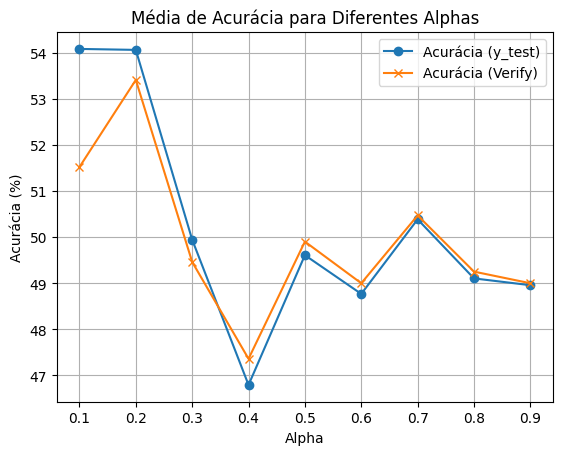

In [10]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import winsound


# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por alpha
mean_accuracy_by_alpha = []

# Loop para cada alpha e realização de validação cruzada em série temporal
for alpha in alpha_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}',
                    f'r_percent_{alpha:.2f}',
                    f'Price_Rate_Of_Change_{alpha:.2f}',
                    f'MACD_{alpha:.2f}',
                    f'MACD_EMA_{alpha:.2f}',
                    f'OBV_{alpha:.2f}']]
    y = price_data[f'Prediction_{alpha:.2f}']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse alpha
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []

    print(f'Alpha: {alpha}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por alpha
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_alpha.append((alpha, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para alpha {alpha}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para alpha {alpha}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for alpha, acc_ytest, acc_verify in mean_accuracy_by_alpha:
    print(f'Alpha: {alpha:.2f} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por alpha
import matplotlib.pyplot as plt

alphas, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_alpha)

plt.plot(alphas, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(alphas, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Alphas")
plt.xlabel('Alpha')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
winsound.Beep(440, 300)

#### Time Series com verify

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Loop para cada alpha e realização de validação cruzada em série temporal
for alpha in alpha_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}',
                    f'r_percent_{alpha:.2f}',
                    f'Price_Rate_Of_Change_{alpha:.2f}',
                    f'MACD_{alpha:.2f}',
                    f'MACD_EMA_{alpha:.2f}',
                    f'OBV_{alpha:.2f}']]
    y = price_data[f'Prediction_{alpha:.2f}']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    print(f'Alpha: {alpha}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar os resultados das acurácias
        all_accuracy_scores_ytest.append(accuracy_ytest)
        all_accuracy_scores_verify.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    print('---')

# Resultados gerais
print("Resumo geral:")
print(f'Média de acurácia (y_test): {np.mean(all_accuracy_scores_ytest):.2f}%')
print(f'Média de acurácia (Verify): {np.mean(all_accuracy_scores_verify):.2f}%')


Alpha: 0.1
Fold 1:
 - Correct Prediction (y_test): 60.90%
 - Correct Prediction (Verify): 49.16%
Fold 2:
 - Correct Prediction (y_test): 67.82%
 - Correct Prediction (Verify): 48.74%
Fold 3:
 - Correct Prediction (y_test): 61.64%
 - Correct Prediction (Verify): 40.67%
Fold 4:
 - Correct Prediction (y_test): 64.05%
 - Correct Prediction (Verify): 57.44%
Fold 5:
 - Correct Prediction (y_test): 70.65%
 - Correct Prediction (Verify): 51.57%
---
Alpha: 0.2
Fold 1:
 - Correct Prediction (y_test): 53.25%
 - Correct Prediction (Verify): 50.21%
Fold 2:
 - Correct Prediction (y_test): 59.22%
 - Correct Prediction (Verify): 55.24%
Fold 3:
 - Correct Prediction (y_test): 58.07%
 - Correct Prediction (Verify): 45.70%
Fold 4:
 - Correct Prediction (y_test): 58.60%
 - Correct Prediction (Verify): 55.45%
Fold 5:
 - Correct Prediction (y_test): 55.45%
 - Correct Prediction (Verify): 48.32%
---
Alpha: 0.3
Fold 1:
 - Correct Prediction (y_test): 49.37%
 - Correct Prediction (Verify): 48.22%
Fold 2:
 - Co

#### Time Series sem Verify

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Loop para cada alpha e realização de validação cruzada em série temporal
for alpha in alpha_list:
    # Definir as features (X) e o target (Y) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}',
                    f'r_percent_{alpha:.2f}',
                    f'Price_Rate_Of_Change_{alpha:.2f}',
                    f'MACD_{alpha:.2f}',
                    f'MACD_EMA_{alpha:.2f}',
                    f'OBV_{alpha:.2f}']]
    y = price_data[f'Prediction_{alpha:.2f}']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y], axis=1).dropna()
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    print(f'Alpha: {alpha}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0,oob_score = True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Calcular e imprimir a acurácia para cada divisão
        accuracy = accuracy_score(y_test, y_pred) * 100.0
        print(f'Fold {fold}: Correct Prediction (%): {accuracy:.2f}')
        fold += 1

    print('---')


#### Salvando

In [ ]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

In [ ]:
price_data.to_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/test_day.xlsx', index=False)